<a href="https://colab.research.google.com/github/Autobot37/jupyter/blob/main/CLIPGUIDANCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd

In [50]:
im = Image.open('logo.png')

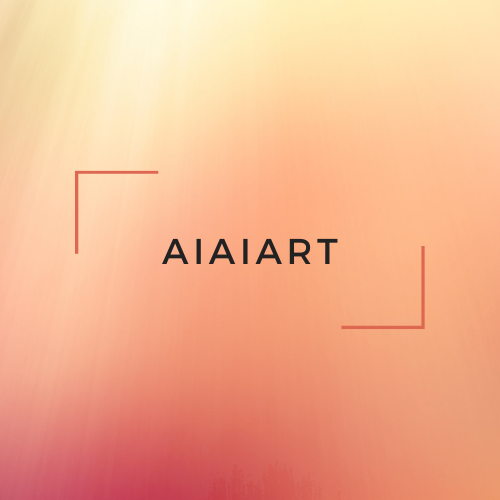

In [51]:
im

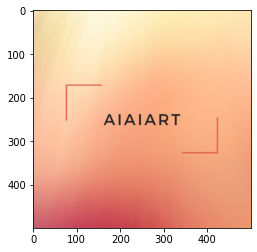

In [52]:
im_array = np.array(im)
plt.imshow(im_array)

In [53]:
##now we are going to use clip by openai it is jointly trained model of text and images by encoding them in latent space and contrastive learning.
# so instead of normal loss fn we can use clip loss fn 

here we have to download some libraries 
1-clip by openai
2-some helpful functions


In [58]:
!git clone https://github.com/openai/CLIP                 
!pip install -q  ftfy regex tqdm omegaconf pytorch-lightning 

Cloning into 'CLIP'...
remote: Enumerating objects: 236, done.
remote: Total 236 (delta 0), reused 0 (delta 0), pack-reused 236
Receiving objects: 100% (236/236), 8.92 MiB | 29.09 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [62]:
from CLIP import clip
from torchvision import transforms #image transforms
import torch.nn.functional as F #some extr pytorch nn
from tqdm.notebook import tqdm #progress bar


device = torch.device('cuda:0' if torch.cuda.is_available() else'cpu')
perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device) 
#provided by openai repo, jit false, do it in eval mode and we dont need grads and load to device
#the vision transformers model Vit-B/32
print(perceptor.visual.input_resolution)


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 131MiB/s]


224


In [63]:
#tokenize and embed text 
text_embed = perceptor.encode_text(clip.tokenize("A watercolor painting of lighthouse over sunset"))
text_embed.shape

torch.Size([1, 512])

here text is embeded in clip's latent space ,
now we will pass a random image and calculates its embedding in clip's latent space
and minimise loss(or we improve pixels to look like text)

In [67]:
im = torch.rand(1 ,3, 224, 224) # batch, channnel, w, h , clip takes this dims
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],std=[0.26862954, 0.26130258, 0.27577711])
#again this transform is described in clip repo so this is necessary

image_embed  = perceptor.encode_image(normalize(im).to(device)).float()
image_embed.shape

torch.Size([1, 512])

In [68]:
def clip_loss(im, text_embed):
  image_embed = perceptor.encode_image(normalize(im).to(device)).float()
  loss = torch.mean((image_embed - text_embed)**2)**0.5 # Root Mean Squared Error
  return loss

clip_loss(im, text_embed)
  

tensor(0.4871)

now both are [1,512] so we will optimize pixels to  match text and image

In [69]:
text_embed = perceptor.encode_text(clip.tokenize("A watercolor painting of the sunset over a mountain range").to(device)).float()

# The image we'll be optimizing
im = torch.rand(1, 3, 224, 224)

In [70]:
im.requires_grad = True

In [72]:
start_im = im.detach().clone()#make clone

optimizer = torch.optim.SGD([im], lr=500) #the landscape is difficult here so LEARNING RATE IS blundered

losses = []

for i in tqdm(range(100)):

  optimizer.zero_grad()

  loss = clip_loss(im, text_embed)

  if i%50==0: #store in a while
    print(i, loss)
  losses.append(loss.detach().item())
   
  loss.backward()

  optimizer.step()




  

  0%|          | 0/100 [00:00<?, ?it/s]

0 tensor(0.4901, grad_fn=<PowBackward0>)
50 tensor(0.2313, grad_fn=<PowBackward0>)


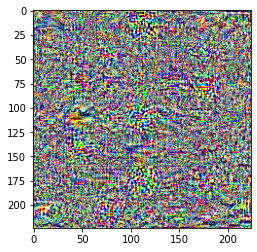

In [74]:
plt.imshow(im.squeeze().detach().permute(1,2,0)) #to show we have to squeeze batch, detach grads and dim=w*h*c


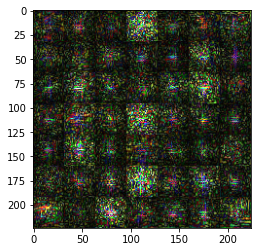

In [75]:
plt.imshow(torch.abs(im.detach()-start_im).squeeze().permute(1,2,0))

Above we can see effect od Vision Transformer for creating blobs


In [76]:
# Specifying some transforms to apply to our image:
tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(5),
])

# Our new and improved loss function
def clip_loss(im, text_embed):
  image_embed = perceptor.encode_image(tfms(im).to(device)).float()
  input_normed = F.normalize(image_embed.unsqueeze(1), dim=2)
  embed_normed = F.normalize(text_embed.unsqueeze(0), dim=2)
  dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
  return dists.mean()

# The target text as a parameter:
prompt = "A watercolor painting of the sunset over a mountain range" #@param
text_embed = perceptor.encode_text(clip.tokenize(prompt).to(device)).float()

# The image we'll be optimizing
im = torch.rand(1, 3, 224, 224)
im.requires_grad = True

# Make a copy of the starting image
start_im = im.detach().clone()

# The optimizer
learning_rate = 50 #@param
optimizer = torch.optim.SGD([im], lr=learning_rate)

losses = [] # Keep track of our losses (RMSE values)

n_iterations = 200 #@param
for i in tqdm(range(n_iterations)):

  # Reset everything related to gradient calculations
  optimizer.zero_grad()

  # Calculate our loss
  loss = clip_loss(im.clip(0, 1), text_embed) # note .clip(0, 1)

  # Store the loss for later
  if i % 50 == 0:
    print(i, loss)
  losses.append(loss.detach().item())

  # Backpropagate the loss and use it to update the parameters
  loss.backward() # This does all the gradient calculations
  optimizer.step()

  0%|          | 0/200 [00:00<?, ?it/s]

0 tensor(0.9246, grad_fn=<MeanBackward0>)
50 tensor(0.7338, grad_fn=<MeanBackward0>)
100 tensor(0.7126, grad_fn=<MeanBackward0>)
150 tensor(0.7461, grad_fn=<MeanBackward0>)


with some improvements
1- forcing pixels >0 
2- some transforms applying
3 - rmse is not nice for high dims so improved loss fn


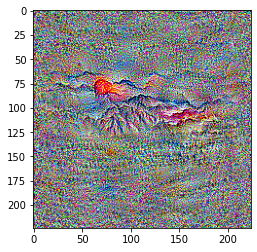

In [77]:
plt.imshow(im.squeeze().detach().permute(1,2,0))

IT looks like something but some improvements can be made
1- use advanced optim like Adam 
2- use some  tricks like below


In [82]:
im = torch.rand(1,3,224,224)
im.requires_grad = True

optimizer = torch.optim.Adam([im], lr=0.05, weight_decay=1e-6)

for i in tqdm(range(100)):


  # Specifying some transforms to apply to our image:
    tfms = transforms.Compose([
       transforms.RandomResizedCrop(224),
       transforms.RandomAffine(5),
       transforms.ColorJitter(),
       transforms.GaussianBlur(5),
])
    
    optimizer.zero_grad()

    loss = 0
    for _ in range(4):
      loss += clip_loss(tfms(im).clip(0,1), text_embed)

    if i% 50 ==0:
      print(i, loss)
    losses.append(loss.detach().item())

    loss.backward()
    optimizer.step() 

  
 


  



  0%|          | 0/100 [00:00<?, ?it/s]

0 tensor(3.7410, grad_fn=<AddBackward0>)
50 tensor(2.9255, grad_fn=<AddBackward0>)


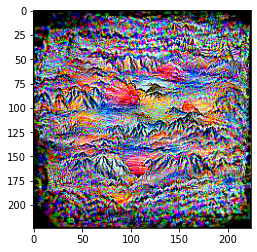

In [83]:
plt.imshow(im.squeeze().detach().permute(1,2,0))

thats it,
IN the next ipynb we will do same thing in latent space,
first by decoding via VAE
then stylegan,


*THANKS*